<a href="https://colab.research.google.com/github/sgering/sgering/blob/main/Mask_NoMask_YOLO_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask Detection with YOLO

1. Mount the directory.  This enables you to save the source files to google drive so that they can be preserved between sessions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2.  Navigate to Darknet.  Woring for the root of Darknet provides a simple file strucutre for small projects.

In [ ]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
%cd darknet

/content/drive/My Drive/darknet



We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [ ]:
!git clone https://github.com/AlexeyAB/darknet.git


Cloning into 'darknet'...
remote: Enumerating objects: 15308, done.
remote: Total 15308 (delta 0), reused 0 (delta 0), pack-reused 15308
Receiving objects: 100% (15308/15308), 13.69 MiB | 6.47 MiB/s, done.
Resolving deltas: 100% (10406/10406), done.
Checking out files: 100% (2044/2044), done.
/content/drive/My Drive/darknet


3.  Build / compile darknet 

Note that this only needs to be executed once

In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


In [ ]:
#Uncomment and run if already built for inference
!chmod a+x darknet

4.  Upload and Unzip the image data.  The name of the older doessn't matter, but for this exercise, I reused the name from ambulance project 'OID-data'.

In [ ]:
#%cd OID-data/
!unzip mask_no-mask_dataset.zip -d /content/drive/MyDrive/darknet/OID-data

Archive:  mask_no-mask_dataset.zip
  inflating: /content/drive/MyDrive/darknet/OID-data/0.jpg  
  inflating: /content/drive/MyDrive/darknet/OID-data/0.txt  
  inflating: /content/drive/MyDrive/darknet/OID-data/1.jpeg  
  inflating: /content/drive/MyDrive/darknet/OID-data/1.txt  
  inflating: /content/drive/MyDrive/darknet/OID-data/10.jpeg  
  inflating: /content/drive/MyDrive/darknet/OID-data/10.txt  
  inflating: /content/drive/MyDrive/darknet/OID-data/100.jpg  
  inflating: /content/drive/MyDrive/darknet/OID-data/100.txt  
  inflating: /content/drive/MyDrive/darknet/OID-data/1000.jpg  
  inflating: /content/drive/MyDrive/darknet/OID-data/1000.txt  
  inflating: /content/drive/MyDrive/darknet/OID-data/1001.jpg  
  inflating: /content/drive/MyDrive/darknet/OID-data/1001.txt  
  inflating: /content/drive/MyDrive/darknet/OID-data/1002.jpg  
  inflating: /content/drive/MyDrive/darknet/OID-data/1002.txt  
  inflating: /content/drive/MyDrive/darknet/OID-data/1003.jpg  
  inflating: /content

5.  Prepare dataset files.  this handy script will seperate the files into testing and training folders based on the root directory.

In [ ]:
import random
import os
import subprocess
import sys

image_dir = "./OID-data"
f_val = open("data_test.txt", 'w')
f_train = open("data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

6.  Dowload Yolo Configuration.  For this case, I downloaded the abulance files and configured them manually.  Then renamed the files by replacing abmulance with mask

In [ ]:
#download and rename
!wget "https://www.dropbox.com/sh/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa?dl=1" -O yolov3-ambulance-code.zip
!unzip yolov3-ambulance-code.zip

--2021-09-06 03:52:23--  https://www.dropbox.com/sh/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/dl/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa [following]
--2021-09-06 03:52:23--  https://www.dropbox.com/sh/dl/jfyj1wetf28bgpr/AACGJHIlPyKRO70B9DlAVqWPa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucdcd96f8c118cd24bfc26ae5e8b.dl.dropboxusercontent.com/zip_download_get/A5DAo_jzVa3kSMOQzKf68HMw0LyUloDt4UtTNihn22MBD4zriP4cZTe1BwFZZBs9hhtlX3gOE7PALN6Z7NStgOcuzT84GzM4p1PGyrd62vopvg?dl=1# [following]
--2021-09-06 03:52:24--  https://ucdcd96f8c118cd24bfc26ae5e8b.dl.dropboxusercontent.com/zip_download_get/A5DAo_jzVa3kSMOQzKf68HMw0LyUloDt4UtTNihn22MBD4zriP4cZTe1BwFZZBs9hhtlX3gOE7PAL

7.  Download Convolutional Backbone.  this is the file wiht pre-trained weights.  Much easier to re-use an existing network than to create one from scratch.

In [ ]:
# Original File : https://pjreddie.com/media/files/darknet53.conv.74
#!wget "https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1" -O darknet53.conv.74

--2021-09-06 03:48:05--  https://www.dropbox.com/s/18dwbfth7prbf0h/darknet53.conv.74?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/18dwbfth7prbf0h/darknet53.conv.74 [following]
--2021-09-06 03:48:05--  https://www.dropbox.com/s/dl/18dwbfth7prbf0h/darknet53.conv.74
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c24186ec4914b153f026e8c78.dl.dropboxusercontent.com/cd/0/get/BVq42MZfMJcODSE9gMH3RC6q_f9tcwX3OJUAoMdW4U5Mhl0TeHZZiPiyvkA_QlEubg55qqMfPc-VpAZnUuc1BpBOxjLpQA7BexTBWETRjDuBcoPU2FfjWbyU5JXhXakyfioGe-kJkd1KqiwLQD6hXBAf/file?dl=1# [following]
--2021-09-06 03:48:05--  https://uc7c24186ec4914b153f026e8c78.dl.dropboxusercontent.com/cd/0/get/BVq42MZfMJcODSE9gMH3RC6q_f9tcwX3OJUAoMdW4U5Mhl0TeHZZiPiyvkA_QlEubg55qqMfP

8.  Start Training the model.  the process will output a chart.png file that can be used to evaluate how the model is progressing.

In [ ]:
#Yolo3 Example Setup
#!./darknet detector train yolov3-mask-setup.data yolov3-mask-train.cfg  darknet53.conv.74 -dont_show -map 2> train_log.txt

#Yolo4 Example Setup
!./darknet detector train yolov4-mask-setup.data yolov4-mask-train.cfg  yolov4.conv.137 -dont_show -map 2> train_log.txt

#Ambulance from previous example for reference
#!./darknet detector train yolov3-mask-setup.data yolov3-mask-train.cfg backup/yolov3-mask-train_last.weights -dont_show -map 2> train_log.txt

Streaming output truncated to the last 5000 lines.
 608 x 608 
 try to allocate additional workspace_size = 52.43 MB 
 CUDA allocate done! 
Loaded: 0.000054 seconds

 (next mAP calculation at 5200 iterations) 
 Last accuracy mAP@0.50 = 89.78 %, best = 91.04 % 
 5131: 1.127612, 1.064419 avg loss, 0.000010 rate, 10.840781 seconds, 328384 images, 1.847336 hours left
Loaded: 0.000089 seconds

 (next mAP calculation at 5200 iterations) 
 Last accuracy mAP@0.50 = 89.78 %, best = 91.04 % 
 5132: 0.609714, 1.018948 avg loss, 0.000010 rate, 10.959783 seconds, 328448 images, 1.855031 hours left
Loaded: 0.000071 seconds

 (next mAP calculation at 5200 iterations) 
 Last accuracy mAP@0.50 = 89.78 %, best = 91.04 % 
 5133: 2.023519, 1.119406 avg loss, 0.000010 rate, 11.648643 seconds, 328512 images, 1.862906 hours left
Loaded: 0.000081 seconds

 (next mAP calculation at 5200 iterations) 
 Last accuracy mAP@0.50 = 89.78 %, best = 91.04 % 
 5134: 1.205170, 1.127982 avg loss, 0.000010 rate, 11.172337 

9.  Perform Inference.  This first script is handy for opening the source and predicted images side x side.

In [ ]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def display_output(imagePath):
    src = cv2.imread(imagePath,1)
    output = cv2.imread("predictions.jpg")

    plt.figure(figsize=[20,8])
    plt.subplot(121)
    plt.imshow(src[:,:,::-1])
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(output[:,:,::-1])
    plt.title("Predictions")
    plt.show()

10.  Run Prediction .  After the model has been completed, check each image to see how well they compare to the original.

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	                           ->  208 x 208 x 128 
  10 conv     64       

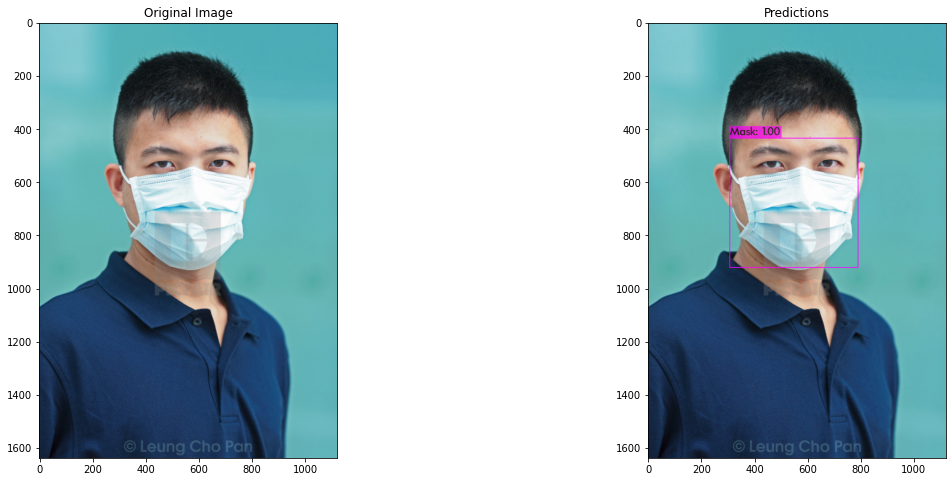

In [ ]:
!chmod a+x darknet
!./darknet detector test yolov4-mask-setup.data yolov4-mask-test.cfg backup/yolov4-mask-train_best.weights test-image1.jpg -thresh .6 2 > /dev/null
display_output("test-image1.jpg")

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	                           ->  208 x 208 x 128 
  10 conv     64       

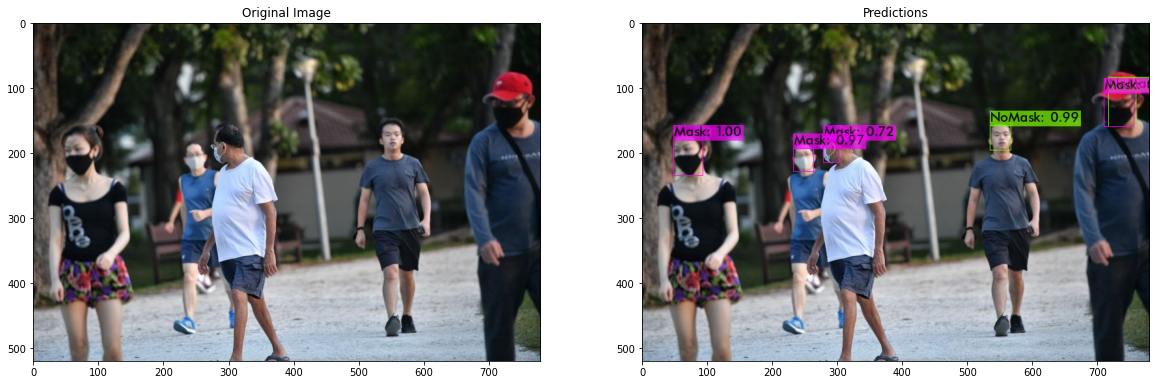

In [ ]:
!./darknet detector test yolov4-mask-setup.data yolov4-mask-test.cfg backup/yolov4-mask-train_best.weights test-image2.jpg -thresh .6 2 > /dev/null
display_output("test-image2.jpg")

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	                           ->  208 x 208 x 128 
  10 conv     64       

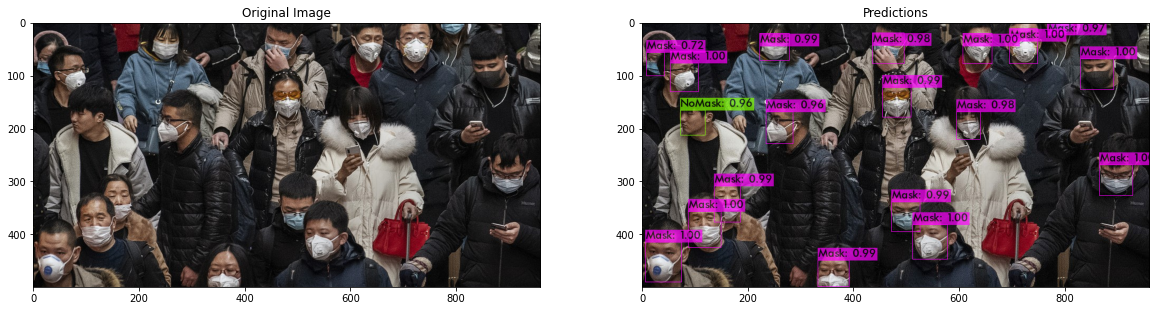

In [ ]:
!./darknet detector test yolov4-mask-setup.data yolov4-mask-test.cfg backup/yolov4-mask-train_best.weights test-image3.jpg -thresh .6 2 > /dev/null
display_output("test-image3.jpg")

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	                           ->  208 x 208 x 128 
  10 conv     64       

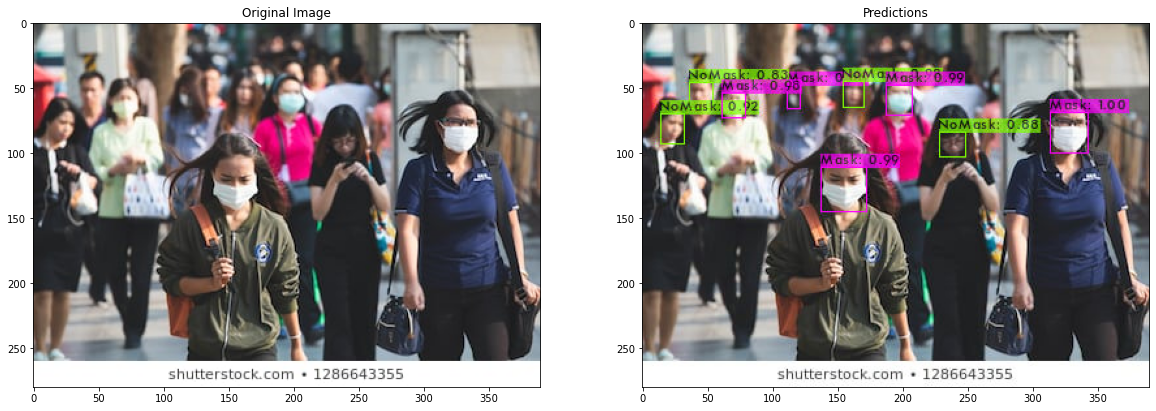

In [ ]:
!./darknet detector test yolov4-mask-setup.data yolov4-mask-test.cfg backup/yolov4-mask-train_best.weights test-image4.jpg -thresh .6 2 > /dev/null
display_output("test-image4.jpg")

In [ ]:
!chmod a+x darknet
#For movie files, need to change 'test' to 'data' for arguement following 'detector'  otherwise an error is generated saying it can't find the correct image.

!./darknet detector demo yolov4-mask-setup.data yolov4-mask-test.cfg backup/yolov4-mask-train_best.weights test-video1.avi -thresh .6 -out_filename out-vid1.avi -dont_show

Streaming output truncated to the last 5000 lines.
NoMask: 100% 
NoMask: 99% 
NoMask: 95% 
NoMask: 78% 
Mask: 94% 

FPS:11.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 99% 
NoMask: 99% 
NoMask: 94% 
Mask: 99% 

FPS:11.1 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 99% 
NoMask: 98% 
NoMask: 94% 
Mask: 97% 

FPS:11.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 98% 
NoMask: 98% 
NoMask: 94% 
Mask: 99% 

FPS:11.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 98% 
NoMask: 97% 
NoMask: 93% 
Mask: 99% 

FPS:11.0 	 AVG_FPS:11.6

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 98% 
NoMask: 97% 
NoMask: 93% 
Mask: 99% 

FPS:11.0 	 AVG_FPS:11.6

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 99% 
NoMask: 93% 
NoMask: 91% 
Mask: 99% 

FPS:11.0 	 AVG_FPS:11.6

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 99% 
NoMask: 93% 
NoMask: 90% 
Mask: 99% 
Mask: 67% 

FPS:11.2 	 AVG_FPS:11.6

 cvWriteFrame 
Objects:

NoMask: 100% 
NoMask: 

In [ ]:
#For video, need to change keyword test to demo

!./darknet detector demo yolov4-mask-setup.data yolov4-mask-test.cfg backup/yolov4-mask-train_best.weights test-video2.mp4 -thresh .6 -out_filename yolov4_out-vid2.avi -dont_show

Streaming output truncated to the last 5000 lines.

 cvWriteFrame 
Objects:

NoMask: 98% 
NoMask: 98% 
NoMask: 88% 
Mask: 96% 

FPS:12.0 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 97% 
NoMask: 89% 
NoMask: 74% 
Mask: 83% 

FPS:11.9 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 99% 
NoMask: 96% 
NoMask: 79% 
Mask: 91% 

FPS:11.7 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 98% 
NoMask: 96% 
Mask: 95% 

FPS:11.7 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 98% 
NoMask: 97% 
Mask: 98% 

FPS:11.7 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 98% 
NoMask: 96% 
Mask: 98% 

FPS:11.6 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 98% 
NoMask: 92% 
NoMask: 80% 
Mask: 99% 

FPS:11.6 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 96% 
NoMask: 88% 
Mask: 96% 

FPS:11.7 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 98% 
NoMask: 77% 
Mask: 91% 

FPS:11.8 	 AVG_FPS:11.9

 cvWriteFrame 
Objects:

NoMask: 98% 
NoMask: 94% 
Mask: 97% 

FPS:11.8 	 AVG_FPS:11.9

 cvWriteFrame 
O

11.  Run Prediction Videos